<a href="https://colab.research.google.com/github/xb24/Deep-Network-Models/blob/main/DelosNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
!wget -O pset2.zip "https://duke.box.com/shared/static/bi28rrhpvk212gbdeguzchcazcypxdd6.zip"
!unzip pset2.zip

--2022-02-19 21:47:39--  https://duke.box.com/shared/static/bi28rrhpvk212gbdeguzchcazcypxdd6.zip
Resolving duke.box.com (duke.box.com)... 107.152.26.197
Connecting to duke.box.com (duke.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/bi28rrhpvk212gbdeguzchcazcypxdd6.zip [following]
--2022-02-19 21:47:39--  https://duke.box.com/public/static/bi28rrhpvk212gbdeguzchcazcypxdd6.zip
Reusing existing connection to duke.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://duke.app.box.com/public/static/bi28rrhpvk212gbdeguzchcazcypxdd6.zip [following]
--2022-02-19 21:47:39--  https://duke.app.box.com/public/static/bi28rrhpvk212gbdeguzchcazcypxdd6.zip
Resolving duke.app.box.com (duke.app.box.com)... 107.152.26.201
Connecting to duke.app.box.com (duke.app.box.com)|107.152.26.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcl

In [ ]:
"""
run_visualize_features.py
  Visualizes DelosNet component tuning profiles via gradient ascent on image input.

"""

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import argparse
import os
import tqdm
import scipy.ndimage as nd
from torchvision import transforms, datasets
from torchsummary import summary


# 1. Repair DelosNet

In [ ]:
DelosNet_broken = torch.load('pset2/DelosNet_broken.pth')
DelosNet_weights = torch.load('pset2/DelosNet_weights.pth')

### a. Add the 7 missing layers to the pytorch model object they give you, and load in the full set of model parameters into this repaired DelosNet

In [ ]:
l = [module for module in DelosNet_broken.modules() if not isinstance(module, nn.Sequential)]
l.extend([nn.Linear(7*7*512, 4096),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.5),
          nn.Linear(4096, 4096),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.5),
          nn.Linear(4096, 1000)])

In [ ]:
# l = [module for module in DelosNet_broken.modules()]
DelosNet = nn.Sequential(*l)
DelosNet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
DelosNet.load_state_dict(DelosNet_weights)

<All keys matched successfully>

### b. Pass an image through DelosNet and plot the output from the 1000 readout neurons in a simple line graph.

--2022-02-19 21:48:36--  https://raw.githubusercontent.com/kevinjliang/PyTorchTutorials/master/Figures/chapel.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 302781 (296K) [image/jpeg]
Saving to: ‘chapel.jpg’

chapel.jpg          100%[===================>] 295.68K  --.-KB/s    in 0.005s  

2022-02-19 21:48:36 (57.5 MB/s) - ‘chapel.jpg’ saved [302781/302781]

Shape of the image tensor: (620, 1175, 3)


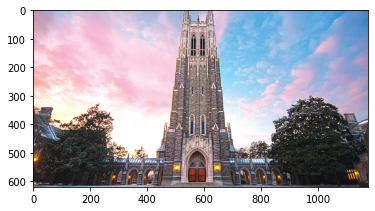

In [ ]:
!wget https://raw.githubusercontent.com/kevinjliang/PyTorchTutorials/master/Figures/chapel.jpg
im = imageio.imread("./chapel.jpg")
print("Shape of the image tensor: {}".format(im.shape))
plt.imshow(im)

In [ ]:
im = Image.open('chapel.jpg')

In [ ]:
# mu and sigma are the mean and standard deviation of the red, green, and
#   blue channels across the entire ImageNet dataset. Because they were used
#   to normalize input images when training DelosNet, they must be used to
#   normalize all subsequent input images.
mu = np.array([0.485, 0.456, 0.406])
sigma = np.array([0.229, 0.224, 0.225])
transform_input = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mu, sigma)])
image = transform_input(im).unsqueeze(0)

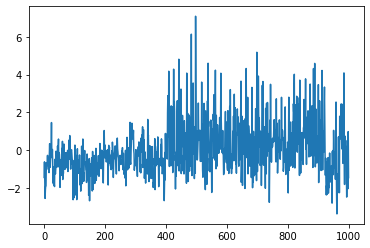

In [ ]:
input = image
out = DelosNet(input)
plt.plot(np.arange(1000),np.squeeze(out.detach().numpy()))

# 2. Investigate the feature processing hierarchy

In [ ]:
def postprocess(im):
    """
    Un-normalizes final image output (im)
    """

    im = im.squeeze().transpose(1, 2, 0)
    im = im * sigma.reshape((1, 1, 3)) + mu.reshape((1, 1, 3))

    return im

In [ ]:
def clamp_image(im):
    """
    Clamps the image data (im) to prevent runaway ascent
    """

    for channel in range(3):
        mu_channel = mu[channel]
        sigma_channel = sigma[channel]

        im[0, channel] = torch.clamp(im[0, channel],
                                     -mu_channel / sigma_channel,
                                     (1 - mu_channel) / sigma_channel)
    return im

### a. Completes the ascent() function, which calculates the gradient of a target network component with respect to an input image and updates the image pixel values by taking a step in the gradient's direction.

In [ ]:
def gradient_ascent(image,
                    component_index,
                    model,
                    iters,
                    lr):
    """
    Performs gradient ascent on the <image> for <iters> iterations using <lr>
        learning rate to increase the activation of target components in <model>.
        Specific components are selected by using <component_index> to slice into
        the model's output tensor.
    """
    # Write a loop performing gradient ascent on the image. At the end of each
    #   iteration, apply clamp_image() to prevent runaway pixel updates.
    #
    # Your results should also look better if, in each iteration before you,
    #   take a step, you divide the learning rate by the mean of the absolute
    #   values of all image pixel gradients
    #
    # For constructing <component_index>, it might be useful to make use of
    #   numpy.s_ (https://numpy.org/doc/stable/reference/generated/numpy.s_.html)

    # ---- Code Here ----
    # ...
    # ...
    # ...
    DelosNet_ga = DelosNet[np.s_[:component_index[0]]]
    input = torch.tensor(image, requires_grad=True)

    for i in range(0,iters):
      out = DelosNet_ga(input)
      out_size = out.shape
      # print(out_size)
      # batch = out.shape[0]
      # layer = out.shape[1]
      channel = out.shape[1]
      # print(channel)
      neuron_y = out.shape[2]
      # print(neuron_y)
      neuron_x = out.shape[3]
      # print(neuron_x)
      loss = torch.norm(out[:,component_index[1],component_index[2],component_index[3]])
      loss.backward()
      gradient = input.grad.data.numpy()
      mean_gradient = np.average(abs(gradient))
      update_gradient = (gradient*lr)/mean_gradient
      input.data = input.data + update_gradient
      input.data = clamp_image(input.data)
      input.grad.data.zero_()
    return input.cpu().data.numpy()


### b. Uses DelosNet, variables indicating the target network component(s), and an input image to run visualize_features(), which transforms the input image to reveal the target component's tuning.

In [ ]:
def visualize_features(image,
                       component_index,
                       model,
                       iters = 20,
                       lr = 0.01,
                       pyramid_scale = 1.4,
                       num_levels = 10):
    """
    Main deep dream method
    """
    image = transform_input(image).unsqueeze(0).cpu().data.numpy()
    # print(np.shape(image))
    # Create multiple copies of the image at different resolutions
    pyramids = [image]
    pyramids = pyramids + [nd.zoom(image,
                                   (1, 1, 1/pyramid_scale**(i+1), 1/pyramid_scale**(i+1)),
                                   order=1) for i in range(num_levels - 1)]

    pyramid_feature = np.zeros_like(pyramids[-1])
    for pyramid, pyramid_base in enumerate(tqdm.tqdm(pyramids[::-1], desc="Visualizing")):
      if pyramid > 0:
          # Resize previous pyramid level's features to match current level's resolution
          pyramid_feature = nd.zoom(pyramid_feature,
                                    np.array(pyramid_base.shape) / np.array(pyramid_feature.shape),
                                    order=1)
      # Add features from previous level to new base
      current_image = pyramid_base + pyramid_feature
      # Get new image at this level
      output_image = gradient_ascent(current_image,
                                     component_index,
                                     model,
                                     iters,
                                     lr)
      # Transfer the new features at this level to the next
      pyramid_feature = output_image - pyramid_base

    return postprocess(output_image)

#### Feature tuning for 5 entire layers

Visualizing: 100%|██████████| 10/10 [03:56<00:00, 23.60s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


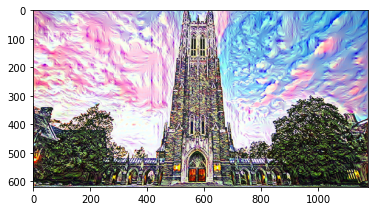

In [ ]:
plt.imshow(visualize_features(im, np.s_[6,:,:,:], DelosNet))#try layer 5

Visualizing: 100%|██████████| 10/10 [06:47<00:00, 40.73s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


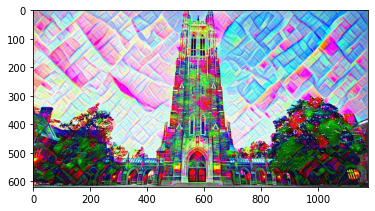

In [ ]:
plt.imshow(visualize_features(im, np.s_[11,:,:,:], DelosNet)) #try layer 10

Visualizing: 100%|██████████| 10/10 [12:58<00:00, 77.90s/it] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


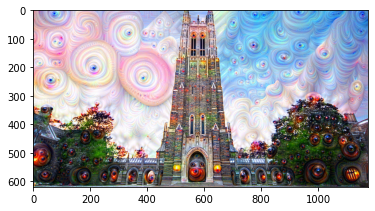

In [ ]:
plt.imshow(visualize_features(im, np.s_[21,:,:,:], DelosNet)) #try layer 20

Visualizing: 100%|██████████| 10/10 [18:50<00:00, 113.06s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


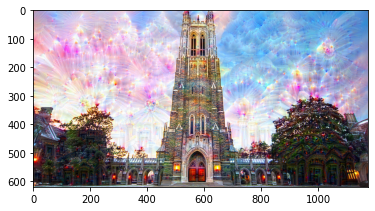

In [ ]:
plt.imshow(visualize_features(im, np.s_[31,:,:,:], DelosNet)) #try layer 30

Visualizing: 100%|██████████| 10/10 [19:47<00:00, 118.71s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


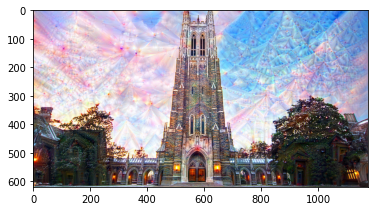

In [ ]:
plt.imshow(visualize_features(im, np.s_[35,:,:,:], DelosNet)) #try layer 40

#### Feature tuning for 5 specific layer channels

Visualizing: 100%|██████████| 10/10 [06:20<00:00, 38.02s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


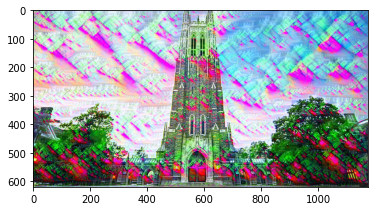

In [ ]:
plt.imshow(visualize_features(im, np.s_[11,0,:,:], DelosNet))

Visualizing: 100%|██████████| 10/10 [06:22<00:00, 38.26s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


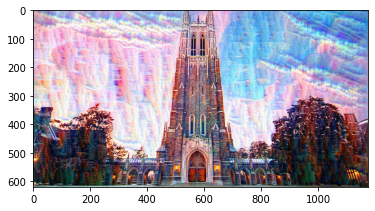

In [ ]:
plt.imshow(visualize_features(im, np.s_[11,20,:,:], DelosNet))

Visualizing: 100%|██████████| 10/10 [06:41<00:00, 40.17s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


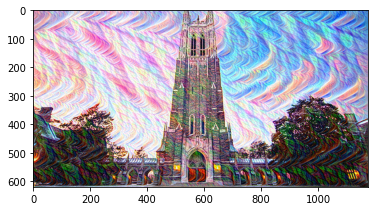

In [ ]:
plt.imshow(visualize_features(im, np.s_[11,40,:,:], DelosNet))

Visualizing: 100%|██████████| 10/10 [12:50<00:00, 77.06s/it] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


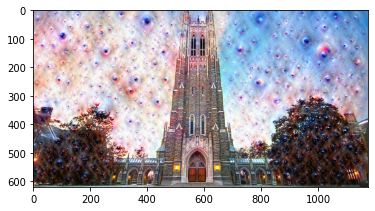

In [ ]:
plt.imshow(visualize_features(im, np.s_[21,20,:,:], DelosNet))

Visualizing: 100%|██████████| 10/10 [12:22<00:00, 74.26s/it] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


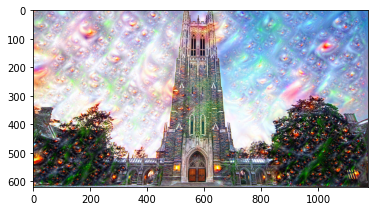

In [ ]:
plt.imshow(visualize_features(im, np.s_[21,30,:,:], DelosNet))

Visualizing: 100%|██████████| 10/10 [19:26<00:00, 116.62s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


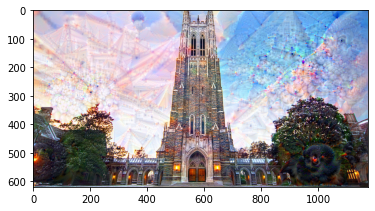

In [ ]:
plt.imshow(visualize_features(im, np.s_[35,10,:,:], DelosNet))

Visualizing: 100%|██████████| 10/10 [19:05<00:00, 114.57s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


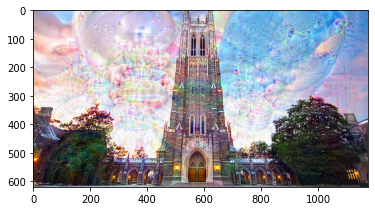

In [ ]:
plt.imshow(visualize_features(im, np.s_[35,50,:,:], DelosNet))

#### Feature tuning for 2 specific neurons

Visualizing: 100%|██████████| 10/10 [03:49<00:00, 22.96s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


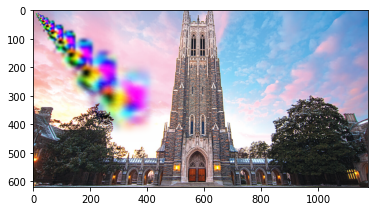

In [ ]:
plt.imshow(visualize_features(im, np.s_[6,14,7,7], DelosNet))

Visualizing: 100%|██████████| 10/10 [14:26<00:00, 86.70s/it] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


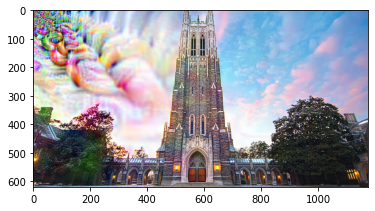

In [ ]:
plt.imshow(visualize_features(im, np.s_[22,3,2,2], DelosNet))

### c. Discuss what you find and what it reveals about the hierarchical organization of feature processing in DelosNet.

As we go from individual layers to specific neurons of a specific layer, the feature being processed goes from the pattern of the entire image to smaller spots. This implies that DelosNet processes features in a hierachical structure by stacking multiple layers of channels of neurons. Specifically, in individual layers, DelosNet processes image in a spatial hierachical order. As the network goes deeper, DelosNet processes image features in a “simple-to-complex” strategy.